In [1]:
import gymnasium as gym
import numpy as np
import gridworld
import matplotlib.pyplot as plt
from collections import defaultdict

# Politica eps-GREEDY
def eps_greedy(Qs, epsilon) -> int:

    # Azione random scelta con probabilità epsilon
    if np.random.rand() < epsilon:
        # Numero di azioni possibili
        N = len(Qs)
        # Azione random tra 0 e N
        action = np.random.randint(0,N)
        
    # Azione greedy scelta con probabilità 1-epsilon
    else:
        action = greedy(Qs)
        
    return action

# Politica GREEDY: Sceglie sempre l'azione con il valore massimo di Q(s,a)
def greedy(Qs) -> int:
    # Valore massimo di Q(s,:)
    Qmax = np.max(Qs)
    id = np.where(Qs == Qmax)[0]
    
    # Se ho più di un massimo, ne scelgo uno in modo random
    if len(id) > 1:
        action = np.random.choice(id)
    # Se ho solo un massimo, scelgo quello
    else:
        action = id[0]
    return action

# Update Q table 
def Q_learning(Q, S, A, R, S2, alpha, gamma, done):
    
    # Caclolo del target quando mi trovo in uno stato terminale
    if done or S2 not in Q:
        delta = R - Q[S][A]
    # Caclolo normale del target
    else:   
        delta = R + gamma * np.max(Q[S2]) - Q[S][A]

    return Q[S][A] + alpha * delta

In [2]:
num_episodes = 2000

# Dati decadimento esponenziale del parametro epsilon
max_epsilon = 1.0                  
min_epsilon = 0.01             
decay_rate = 0.0025

# Parametri learning
gamma = 1
alpha = 0.1

# Init dizionario contenente le Action Value Function per ogni stato
Q ={}

# Variabili raccolta dati
total_reward_ep = np.zeros(num_episodes)
total_steps     = np.zeros(num_episodes)
reward_collected_per_ep = np.zeros(num_episodes)
collisions = np.zeros(num_episodes)
goal = 0

# Init environment
env = gym.make('Ship-v0')

for ep in range(num_episodes):
    # Init ambiente
    done = False
    curr_position, info = env.reset()
    curr_state = (tuple(curr_position), info['reward_collected'])
    
    if ep == 0:
        N_reward = env.get_wrapper_attr('n_reward')
    
    # Decadimento di epsilon
    epsilon = np.max([min_epsilon, max_epsilon * np.exp(-decay_rate * ep)])
    
    while not done:
        # Check item esistente nel dizionario Q
        if curr_state not in Q:
            Q[curr_state] = np.zeros(4)

        # Scelgo l'azione con EPS-GREEDY policy e la applico
        curr_action = eps_greedy(Q[curr_state], epsilon)
        next_position, reward, terminated, truncated, info = env.step(curr_action)
        next_state = (tuple(next_position), info['reward_collected'])
        done = terminated or truncated

        # Update Q table
        Q[curr_state][curr_action] = Q_learning(Q, curr_state, curr_action, reward, next_state, alpha, gamma, done)

        # Passo successivo
        curr_state = next_state

        # Raccolta dati
        goal += info['goal']
        total_reward_ep[ep] += reward
        total_steps[ep] += 1
        reward_collected_per_ep[ep] = info['reward_collected']
        collisions[ep] = info['collision']

    # Running info
    if ep % 100 == 0 and ep!= 0:
        print("Episode number: %d Epsilon value: %f" % (ep, epsilon))
        print("Goal reached %d times" % goal)
env.close()

Episode number: 100 Epsilon value: 0.778801
Goal reached 12 times
Episode number: 200 Epsilon value: 0.606531
Goal reached 17 times
Episode number: 300 Epsilon value: 0.472367
Goal reached 21 times
Episode number: 400 Epsilon value: 0.367879
Goal reached 22 times
Episode number: 500 Epsilon value: 0.286505
Goal reached 31 times
Episode number: 600 Epsilon value: 0.223130
Goal reached 45 times
Episode number: 700 Epsilon value: 0.173774
Goal reached 85 times
Episode number: 800 Epsilon value: 0.135335
Goal reached 136 times
Episode number: 900 Epsilon value: 0.105399
Goal reached 199 times
Episode number: 1000 Epsilon value: 0.082085
Goal reached 261 times
Episode number: 1100 Epsilon value: 0.063928
Goal reached 334 times
Episode number: 1200 Epsilon value: 0.049787
Goal reached 405 times
Episode number: 1300 Epsilon value: 0.038774
Goal reached 493 times
Episode number: 1400 Epsilon value: 0.030197
Goal reached 583 times
Episode number: 1500 Epsilon value: 0.023518
Goal reached 678 ti

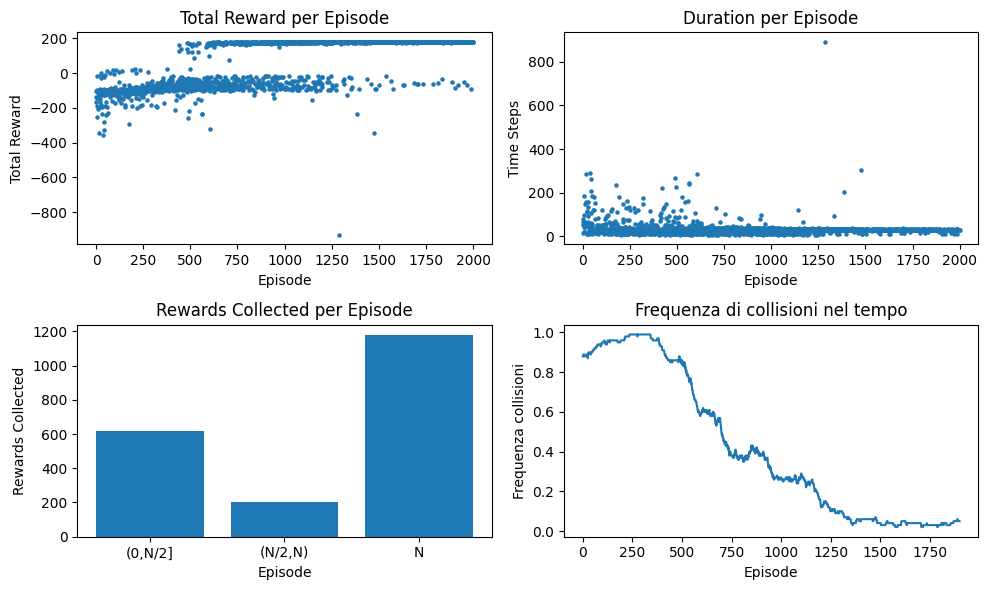

In [3]:
fig, axes = plt.subplots(2,2, figsize=(10, 6))

# Appiattisci la matrice di assi
ax1, ax2, ax3, ax4 = axes.flatten()

# Reward per episodio
ax1.scatter(np.arange(len(total_reward_ep)), total_reward_ep, s=5)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Total Reward per Episode')

# Durata EP
ax2.scatter(np.arange(len(total_steps)), total_steps, s=5)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Time Steps')
ax2.set_title('Duration per Episode')

# Reward raccolti per episodio
fascia_1 = np.sum((reward_collected_per_ep > 0) & (reward_collected_per_ep <= N_reward/2))
fascia_2 = np.sum((reward_collected_per_ep > N_reward/2) & (reward_collected_per_ep < N_reward))
fascia_3 = np.sum(reward_collected_per_ep == N_reward)
counts = [fascia_1, fascia_2, fascia_3]
labels = ['(0,N/2]', '(N/2,N)', 'N']

ax3.bar(labels, counts)
ax3.set_xlabel('Episode')
ax3.set_ylabel('Rewards Collected')
ax3.set_title('Rewards Collected per Episode')

# Numero di collisioni
window_size = 100
collision_freq = np.convolve(collisions, np.ones(window_size)/window_size, mode='valid')

ax4.plot(collision_freq, label='Frequenza di collisione (media mobile)')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Frequenza collisioni')
ax4.set_title('Frequenza di collisioni nel tempo')

# Migliora il layout per evitare sovrapposizioni
plt.tight_layout()
plt.show()

In [4]:
env = gym.make('Ship-v0', render_mode='human')
for ep in range(3):
    curr_position, info = env.reset()
    curr_state = (tuple(curr_position), info['reward_collected'])
    
    curr_action = eps_greedy(Q[tuple(curr_state)], 0)
    done = False
    tot_reward = 0
    while not done:
        
        next_position, reward, terminated, truncated, info = env.step(curr_action)
        next_state = (tuple(next_position), info['reward_collected'])
        done = terminated or truncated
        tot_reward += reward
        if not done:
            next_action = eps_greedy(Q[tuple(next_state)], 0)
            curr_state = next_state
            curr_action = next_action
    print("Info: " + str(info))
    print("Total reward: " + str(tot_reward))
env.close()

Info: {'goal': True, 'reward_collected': 18, 'collision': False}
Total reward: 179
Info: {'goal': True, 'reward_collected': 18, 'collision': False}
Total reward: 179
Info: {'goal': True, 'reward_collected': 18, 'collision': False}
Total reward: 179
